<a href="https://colab.research.google.com/github/mjokeit/PINN_heat/blob/master/notebooks/1Dheat_discrete_strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discrete PINN for heat equation with strong enforcement of boundary conditions

First, check if GPU hardware acceleration is selected in "Runtime" -> "Change runtime type".

# mount google drive (optional)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

if you want to access/store files directly in your google drive

In [ ]:
# import os
# if os.getcwd() != '/content/drive/My Drive/Colab Notebooks/PINNs':
#   os.chdir('/content/drive/My Drive/Colab Notebooks/PINNs')

# download data

In [12]:
!wget https://github.com/mjokeit/PINN_heat/raw/master/discrete_time_inference/data/heat1D.mat

--2020-07-31 17:01:52--  https://github.com/mjokeit/PINN_heat/raw/master/discrete_time_inference/data/heat1D.mat
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mjokeit/PINN_heat/master/discrete_time_inference/data/heat1D.mat [following]
--2020-07-31 17:01:52--  https://raw.githubusercontent.com/mjokeit/PINN_heat/master/discrete_time_inference/data/heat1D.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 820797 (802K) [application/octet-stream]
Saving to: ‘heat1D.mat.1’

heat1D.mat.1        100%[===================>] 801.56K  --.-KB/s    in 0.06s   

2020-07-31 17:01:53 (13.2 MB/s) - ‘heat1D.ma

# download weights

In [15]:
!wget https://github.com/mjokeit/PINN_heat/raw/master/utilities/IRK_weights/Butcher_IRK.zip
!unzip Butcher_IRK.zip 

--2020-07-31 17:07:34--  https://github.com/mjokeit/PINN_heat/raw/master/utilities/IRK_weights/Butcher_IRK.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mjokeit/PINN_heat/master/utilities/IRK_weights/Butcher_IRK.zip [following]
--2020-07-31 17:07:34--  https://raw.githubusercontent.com/mjokeit/PINN_heat/master/utilities/IRK_weights/Butcher_IRK.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6433335 (6.1M) [application/zip]
Saving to: ‘Butcher_IRK.zip.1’

Butcher_IRK.zip.1   100%[===================>]   6.13M  33.5MB/s    in 0.2s    

2020-07-31 17:07:34 (33.5 MB/s) - ‘Butcher_IRK.zip.1’

# install pyDOE

In [2]:
!pip install -q pyDOE

# import plotting

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  9 20:11:57 2017

@author: mraissi
"""

import numpy as np
import matplotlib

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean =  (np.sqrt(5.0)-1.0)/2.0 # 1/0.707       # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
        fig = plt.gcf()
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        fig.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        fig.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
        fig = plt.gcf()
#        plt.savefig('{}.pgf'.format(filename))
        fig.savefig('{}.pdf'.format(filename))
        fig.savefig('{}.eps'.format(filename))

# PINN class

In [20]:
"""
@author: Maziar Raissi
@editor: Moritz Jokeit
"""

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)



class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, x1, layers, t0, dt, lb, ub, q, max_iter):

        self.lb = lb
        self.ub = ub

        self.x0 = x0
        self.x1 = x1

        self.u0 = u0

        self.t0 = t0

        self.layers = layers
        self.dt = dt
        self.q = max(q, 1)

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # Load IRK weights
        tmp = np.float32(np.loadtxt('Butcher_IRK%d.txt' % (q), ndmin=2))
        self.IRK_weights = np.reshape(tmp[0:q ** 2 + q], (q + 1, q))
        self.IRK_times = tmp[q ** 2 + q:]

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q))  # dummy variable for fwd_gradients
        self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q + 1))  # dummy variable for fwd_gradients

        self.U0_pred = self.net_U0(self.x0_tf)  # N x (q+1)
        self.U1_pred, self.U1_x_pred = self.net_U1(self.x1_tf)  # N1 x (q+1)

        # LOSS FOR WEAK ENFORCEMENT OF CONSTRAINTS
        # self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
        #             tf.reduce_sum(tf.square(self.U1_x_pred[0,:])) + \
        #             tf.reduce_sum(tf.square(self.U1_x_pred[-1,:]))

        # LOSS FOR STRONG ENFORCEMENT OF CONSTRAINTS
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.U0_pred))

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': max_iter,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(0.001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.sinh(tf.add(tf.matmul(H, W), b))                         # SINH OUTPUT ACTIVATION
        # Y = tf.add(tf.matmul(H, W), b)                                # LINEAR OUTPUT ACTIVATION
        return Y

    def fwd_gradients_0(self, U, x):
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]

    def fwd_gradients_1(self, U, x):
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]

    def net_U0(self, x):
        U1 = (x-1)*x*self.neural_net(x, self.weights, self.biases)
        U = U1[:, :-1]
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)

        # computations for the rhs
        t_max = 0.5
        sigma = 0.02
        u_max = 800
        t = self.t0 + self.dt * self.IRK_times.T

        p = 0.25 * np.cos(2 * np.pi * t / t_max) + 0.5
        p_t = -0.5*(np.pi * np.sin(2 * np.pi * t / t_max)) / t_max

        u_sol = u_max * tf.exp(-(x - p) ** 2 / (2 * sigma ** 2))

        k_sol = 1.29 * 10 ** -2 * u_sol + 6.856
        k_u_sol = 1.29 * 10 ** -2

        c_sol = 4.55 * 10 ** -4 * u_sol ** 2 - 5.78 * 10 ** -3 * u_sol + 5.849 * 10 ** 2

        fac_sigma = 1 / (sigma ** 2)
        s = fac_sigma * k_sol * u_sol + u_sol * (x - p) * fac_sigma * (
                c_sol * p_t - (x - p) * fac_sigma * (k_sol + u_sol * k_u_sol))


        c = 4.55 * 10 ** -4 * U ** 2 - 5.78 * 10 ** -3 * U + 5.849 * 10 ** 2
        k = 1.29 * 10 ** -2 * U + 6.856
        k_u = 1.29 * 10 ** -2
        k_x = k_u * U_x
        F = (k_x * U_x + k * U_xx + s) / c
        U0 = U1 - self.dt * tf.matmul(F, self.IRK_weights.T)
        return U0

    def net_U1(self, x):
        U1 = (x-1)*x*self.neural_net(x, self.weights, self.biases)
        U1_x = self.fwd_gradients_1(U1, x)
        return U1, U1_x  # N x (q+1)

    def callback(self, loss):
        print('Loss:', loss)

    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q + 1))}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

    def predict(self, x_star):

        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})

        return U1_star



# define main

In [21]:
q = 500
layers = [1, 50, 50, 50, 50, q + 1]
lb = np.array([0])
ub = np.array([1.0])

N = 200
epochs = 10

max_iter = 0

data = scipy.io.loadmat('heat1D.mat')

t = data['ts'].flatten()[:, None]  # T x 1
x = data['xs'].flatten()[:, None]  # N x 1
Exact = np.real(data['usol']).T  # T x N

idx_t0 = 20
idx_t1 = 120
t0 = t[idx_t0]
dt = t[idx_t1] - t[idx_t0]

# Initial data
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False)
x0 = x[idx_x, :]
u0 = Exact[idx_t0:idx_t0 + 1, idx_x].T
u0 = u0 + noise_u0 * np.std(u0) * np.random.randn(u0.shape[0], u0.shape[1])

# Boudanry data
x1 = np.vstack((lb, ub))

# Test data
x_star = x

model = PhysicsInformedNN(x0, u0, x1, layers, t0, dt, lb, ub, q, max_iter)
model.train(epochs)

U1_pred = model.predict(x_star)

error = np.linalg.norm(U1_pred[:, -1] - Exact[idx_t1, :], 2) / np.linalg.norm(Exact[idx_t1, :], 2)
print('Error: %e' % (error))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

It: 0, Loss: 9.661e+04, Time: 0.97
Loss: 96604.914
Loss: 96601.49
Loss: 96594.45
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 96594.453125
  Number of iterations: 1
  Number of functions evaluations: 3
Error: 9.993583e-01


# plotting

No handles with labels found to put in legend.


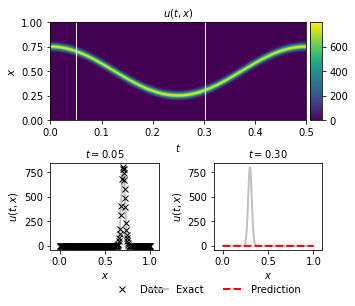

In [22]:
######################################################################
############################# Plotting ###############################
######################################################################

fig, ax = newfig(1.0, 1.2)
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06, bottom=1 - 1 / 2 + 0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='bicubic', cmap='viridis',
            extent=[t.min(), t.max(), x_star.min(), x_star.max()],
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[idx_t0] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[idx_t1] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc='best')
ax.set_title('$u(t,x)$', fontsize=10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1 - 1 / 2 - 0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[idx_t0, :], '-', color='silver', linewidth=2)
ax.plot(x0, u0, 'kx', linewidth=2, label='Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
ax.set_xlim([lb - 0.1, ub + 0.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[idx_t1, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x_star, U1_pred[:, -1], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)
ax.set_xlim([lb - 0.1, ub + 0.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)